<a href="https://colab.research.google.com/github/jcs-lambda/DS-Unit-2-Applied-Modeling/blob/master/module3-permutation-boosting/LS_DS_233_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
%matplotlib inline

!pip install -U --quiet pandas-profiling category_encoders

import pandas as pd
import numpy as np
import sqlite3 as sql
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

import pandas_profiling

from IPython.display import display, HTML
from google.colab import drive

drive.mount('drive')

random_state = 13

def group_syllables(syllables):
  if syllables <= 2:
    return '1-2'
  elif syllables <= 5:
    return '3-5'
  else:
    return '6+'

db_file = '/content/drive/My Drive/android-21-12-primary.sqlite'
conn = sql.connect(db_file)

df_entries = pd.read_sql_query('SELECT entry, entry_rich FROM entries', conn)
print(f'entries: {df_entries.shape}')

# select entries that only contain letters and have at least 3 characters
df_words = df_entries[df_entries['entry'].str.match('^[a-z]{3,}$', case=False)].copy()

# drop entries with no vowels or y's
no_vowelys = ~df_words['entry'].str.contains('[aeiouy]')
df_words.drop(no_vowelys[no_vowelys == True].index, inplace=True)

# fix some errors i found
df_words.loc[df_words['entry']=='finasteride', 'entry_rich'] = chr(183).join(['fin', 'as', 'ter', 'ide'])
df_words.loc[df_words['entry']=='subnuclear', 'entry_rich'] = chr(183).join(['sub', 'nu', 'cle', 'ar'])
df_words.loc[df_words['entry']=='omeprazole', 'entry_rich'] = chr(183).join(['o', 'me', 'pra', 'zole'])
df_words.loc[df_words['entry']=='protocal', 'entry_rich'] = chr(183).join(['pro', 'to', 'cal'])

# create feature 'syllables'
df_words['syllables'] = df_words['entry_rich'].str.split(chr(183)).str.len()

# drop words with more than 10 syllables (only a few of each, tends to skew the models)
df_words = df_words[df_words['syllables'] <= 10]

# create feature 'syllables_group'
df_words['syllables_group'] = df_words['syllables'].apply(group_syllables)

# create feature 'length'
df_words['length'] = df_words['entry'].str.len()

# create vowel related features
#  'num_vowels' - total occurences of 'a', 'e', 'i', 'o', and 'u'
#  'vowel_chunks' - total occurences of sequential vowels (includes y)
#  'max_vowel_chunk_length' - length of longest vowel sequence
#  'ends_with_e' - last letter is 'e'
df_words['num_vowels'] = df_words['entry'].str.count('[aeiou]')
df_words['vowel_chunks'] = df_words['entry'].str.count('[aeiouy]+')
df_words['max_vowel_chunk_length'] = df_words['entry'].str.split('[^aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))
df_words['ends_with_e'] = df_words['entry'].str.endswith('e')

# create features to account for the character 'y'
#  'num_ys' - total occurences of 'y'
#  'ends_in_y' - ends in 'y'
df_words['num_ys'] = df_words['entry'].str.count('y')
df_words['ends_in_y'] = df_words['entry'].str.endswith('y')

# create features accounting for consonants
#  'num_consonants' - total occurences of not 'a', 'e', 'i', 'o', and 'u'
#  'consonant_chunks' - total occurences of sequential consonants (excludes y)
#  'max_consonant_chunk_length' - length of longest consonant sequence
df_words['num_consonants'] = df_words['entry'].str.count('[^aeiou]')
df_words['consonant_chunks'] = df_words['entry'].str.count('[^aeiouy]+')
df_words['max_consonant_chunk_length'] = df_words['entry'].str.split('[aeiouy]+').apply(lambda a_list : max([len(item) for item in a_list]))

display(df_words.head())
df_words.shape

     |████████████████████████████████| 153kB 4.9MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 614kB 42.9MB/s 
     |████████████████████████████████| 235kB 44.0MB/s 
     |████████████████████████████████| 307kB 46.5MB/s 
     |████████████████████████████████| 215kB 43.8MB/s 
     |████████████████████████████████| 51kB 6.9MB/s 
     |████████████████████████████████| 747kB 56.5MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photo

,entry,entry_rich,syllables,syllables_group,length,num_vowels,vowel_chunks,max_vowel_chunk_length,ends_with_e,num_ys,ends_in_y,num_consonants,consonant_chunks,max_consonant_chunk_length
42,Aachen,Aa·chen,2,1-2,6,2,2,1,False,0,False,4,3,2
49,aah,aah,1,1-2,3,2,1,2,False,0,False,1,1,1
50,Aalborg,Aal·borg,2,1-2,7,2,2,1,False,0,False,5,3,2
51,Aalesund,Aa·le·sund,3,3-5,8,3,3,1,False,0,False,5,4,2
52,aalii,aa·li·i,3,3-5,5,4,2,2,False,0,False,1,1,1


(92398, 14)

In [0]:
# function to make a dataframe to predict an arbitrary word
def predict_word(word:str):
  word = pd.Series(word)
  data = {
      'length' : word.str.len(),
      'num_vowels' : word.str.count('[aeiou]'),
      'vowel_chunks' : word.str.count('[aeiou]+'),
      'max_vowel_chunk_length' : word.str.split('[^aeiou]+').apply(lambda a_list : max([len(item) for item in a_list])),
      'starts_with_vowel' : word.str.startswith('[aeiouy]'),
      'ends_with_vowel' : word.str.endswith('[aeiouy]'),
      'num_ys' : word.str.count('y'), 
      'num_consonants' : word.str.count('[^aeiou]'), 
      'consonant_chunks' : word.str.count('[^aeiou]+'),
      'max_consonant_chunk_length' : word.str.split('[aeiou]+').apply(lambda a_list : max([len(item) for item in a_list]))
  }
  return pd.DataFrame(data)

predict_word('disarticulate')

In [3]:
!pip install -U --quiet eli5
import eli5
from eli5.sklearn import PermutationImportance
from xgboost import XGBClassifier

     |████████████████████████████████| 112kB 4.7MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [0]:
from sklearn.metrics import accuracy_score, r2_score, roc_auc_score, roc_curve, recall_score, precision_recall_curve, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from sklearn.tree import DecisionTreeClassifier


In [0]:
target = 'syllables'

features = df_words.columns.drop([target, 'syllables_group', 'entry', 'entry_rich'])

train, df_test = train_test_split(df_words)
df_train, df_val = train_test_split(train)

X_train = df_train[features]
X_val = df_val[features]
X_test = df_test[features]

y_train = df_train[target]
y_val = df_val[target]
y_test = df_test[target]

In [21]:
model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_val)

score = accuracy_score(y_val, y_pred)

print(f'Ridge Classifier CV validation score: {score*100:.2f}%')

permuter = PermutationImportance(
    model,
    scoring = 'accuracy',
    n_iter = 5,
    random_state = random_state
)

permuter.fit(X_val, y_val)

eli5.show_weights(
    permuter,
    top = None,
    feature_names = features.tolist()
)

Ridge Classifier CV validation score: 82.07%


Weight,Feature
0.4535 ± 0.0047,vowel_chunks
0.1210 ± 0.0061,ends_with_e
0.0483 ± 0.0029,consonant_chunks
0.0197 ± 0.0019,max_vowel_chunk_length
0.0171 ± 0.0025,num_vowels
0.0145 ± 0.0025,max_consonant_chunk_length
0.0073 ± 0.0005,num_ys
0.0062 ± 0.0024,length
0.0039 ± 0.0006,ends_in_y
0.0006 ± 0.0012,num_consonants


In [26]:
xgb = XGBClassifier(max_depth=5, n_estimators=1000, n_jobs=-1, random_state=random_state)

eval_set = [(X_train, y_train), (X_val, y_val)]

xgb.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=50)

[0]	validation_0-merror:0.186193	validation_1-merror:0.185916
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.186174	validation_1-merror:0.185685
[2]	validation_0-merror:0.186097	validation_1-merror:0.185743
[3]	validation_0-merror:0.185923	validation_1-merror:0.18557
[4]	validation_0-merror:0.185904	validation_1-merror:0.185685
[5]	validation_0-merror:0.18575	validation_1-merror:0.186147
[6]	validation_0-merror:0.185115	validation_1-merror:0.185859
[7]	validation_0-merror:0.185423	validation_1-merror:0.186494
[8]	validation_0-merror:0.185327	validation_1-merror:0.185859
[9]	validation_0-merror:0.185385	validation_1-merror:0.185743
[10]	validation_0-merror:0.185327	validation_1-merror:0.185743
[11]	validation_0-merror:0.186077	validation_1-merror:0.186609
[12]	validation_0-merror:0.185693	validation_1-merror:0.185455
[13]	validation_0-merror:0.185

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=13,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [28]:
y_pred = xgb.predict(X_val)

score = accuracy_score(y_val, y_pred)

print(f'XGBoostClassifier accuracy score: {score*100:.2f}%')

XGBoostClassifier accuracy score: 82.21%


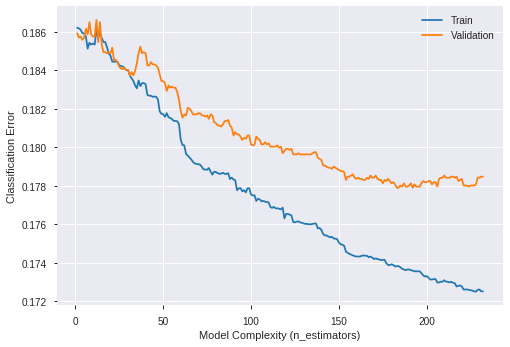

In [29]:
results = xgb.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
#plt.ylim((0.18, 0.22)) # Zoom in
plt.legend();